In [1]:
import warnings                                  
warnings.filterwarnings('ignore')

import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt                  
import seaborn as sns                            

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

%matplotlib inline

In [2]:
car = pd.read_csv('Series/monthly-car-sales.csv')

In [3]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y, autolag='AIC')[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

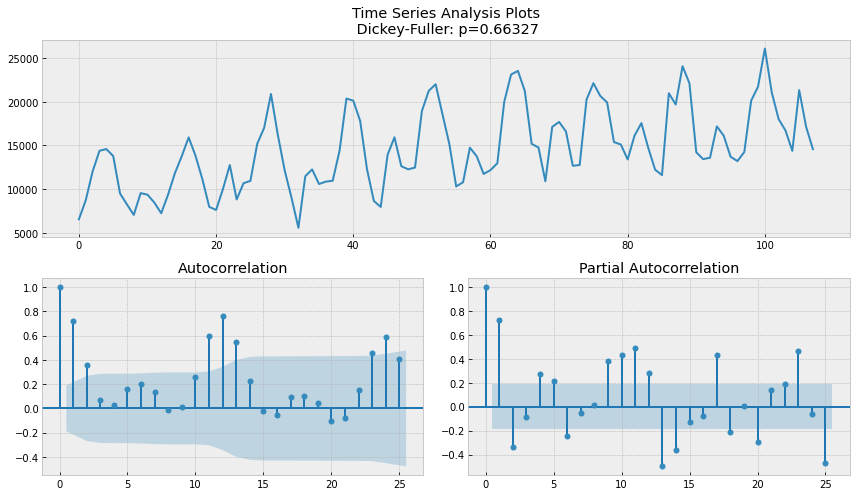

In [4]:
tsplot(car['Sales'], lags=25)

Тест Дики-Фуллера не отвергает нулевую гипотезу о наличии единичного корня.

Для этого уберем тренд и сезонность с которой мы должны разбираться до моделирования. 
Для этого возьмем «сезонную разницу», что означает простое вычитание ряда из самого себя с лагом, равным сезонному периоду.

In [5]:
series = scs.boxcox(car['Sales'], 0)
series = series[2:] - series[:-2]
series = series[12:] - series[:-12]
series

array([-1.15582460e-01, -1.14776076e-01,  1.03663026e-01,  4.55453940e-02,
        7.19079752e-02, -3.61957256e-02, -8.31528389e-02,  8.20892684e-02,
        2.32786946e-01, -6.37450810e-03,  7.95207840e-02,  1.13433543e-01,
       -1.38819930e-01,  5.51673606e-02,  2.17309563e-02, -5.11622452e-02,
       -1.85854791e-01, -3.85511222e-02, -3.98368623e-01,  1.54200973e-02,
        2.72205957e-01,  4.66810506e-02,  5.73998564e-02, -1.81037752e-01,
       -7.08986237e-02,  1.79060617e-01,  1.60827809e-02, -8.59264591e-02,
        4.78786526e-02, -1.35034244e-01,  3.47402927e-01,  2.34361897e-01,
       -9.50792137e-02, -1.74371157e-02, -1.40922817e-01, -4.80502528e-02,
        1.52269620e-01, -8.63420016e-02, -1.84299731e-01, -2.32752946e-04,
        1.23042932e-01,  1.34049589e-01,  9.14698036e-02, -1.18901898e-01,
       -4.51375904e-01, -1.30275443e-01,  1.40215641e-01,  1.12012788e-01,
        6.07802591e-02,  4.52062890e-02,  1.32746528e-02,  4.99422074e-02,
       -6.60973979e-02,  

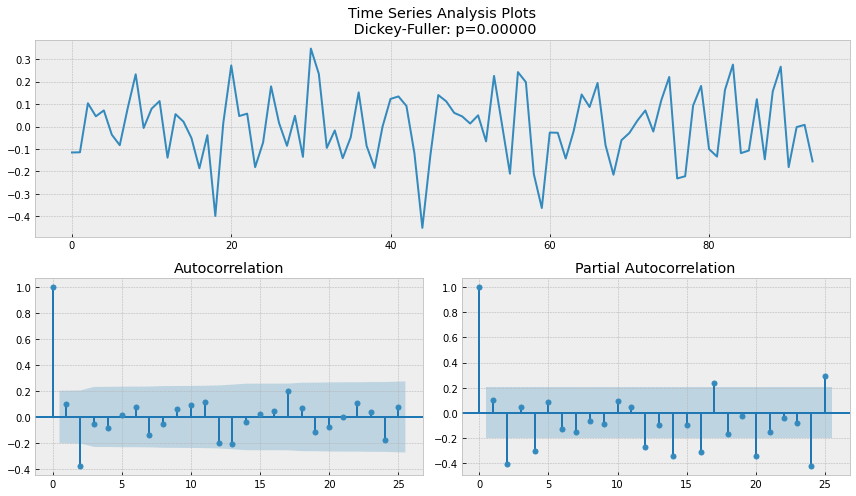

In [6]:
tsplot(series, lags=25)

На графике - у нас нет видимого тренда, поэтому среднее значение постоянно, а дисперсия в значительной степени стабильна.

### ARIMA

In [7]:
# setting initial values and some bounds for them
ps = range(0, 12)
d = range(0, 5)
qs = range(0, 5)

# creating list with all the possible combinations of parameters
parameters = product(ps, d, qs)
parameters_list = list(parameters)

In [8]:
def optimizeSARIMA(parameters_list):
    """
        Return dataframe with parameters and corresponding AIC
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=smt.ARIMA(car['Sales'], order=(param[0], param[1], param[2])).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [9]:
%%time

import warnings                                  
warnings.filterwarnings('ignore')

result_table = optimizeSARIMA(parameters_list)

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 5min 31s, sys: 43 s, total: 6min 14s
Wall time: 2min 6s


In [10]:
result_table.head()

,parameters,aic
0,"(11, 1, 1)",1916.837685
1,"(10, 1, 1)",1921.815218
2,"(9, 1, 2)",1922.487495
3,"(8, 1, 2)",1925.882607
4,"(10, 1, 3)",1928.152585


In [11]:
# set the parameters that give the lowest AIC
p, d, q = result_table.parameters[0]

## GARCH

In [12]:
from arch import arch_model

In [13]:
am = arch_model(series, vol="Garch", p=p, o=d, q=q, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
scale = res.scale
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                44.1192
Distribution:      Standardized Student's t   AIC:                          -56.2384
Method:                  Maximum Likelihood   BIC:                          -15.5457
                                              No. Observations:                   94
Date:                      Sun, Jul 25 2021   Df Residuals:                       93
Time:                              18:12:10   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

In [15]:
def plotGARCH(series, model, n_steps):
    
    # adding model values
    data = pd.DataFrame(series.copy())
    data.columns = ['actual']
    res = model.fit(update_freq=5, disp='off')
    data['ARCH_model'] = pd.Series(res.resid)
    # making a shift on s+d steps, because these values were unobserved by the model
    
    error = mean_absolute_percentage_error(data['actual'], data['ARCH_model'])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(data['ARCH_model'], color='r', label="model")
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management,  [0,+∞)

$$MAPE=100/n ∑^n i=1 ~|yi−ŷ i|~/~yi$$

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

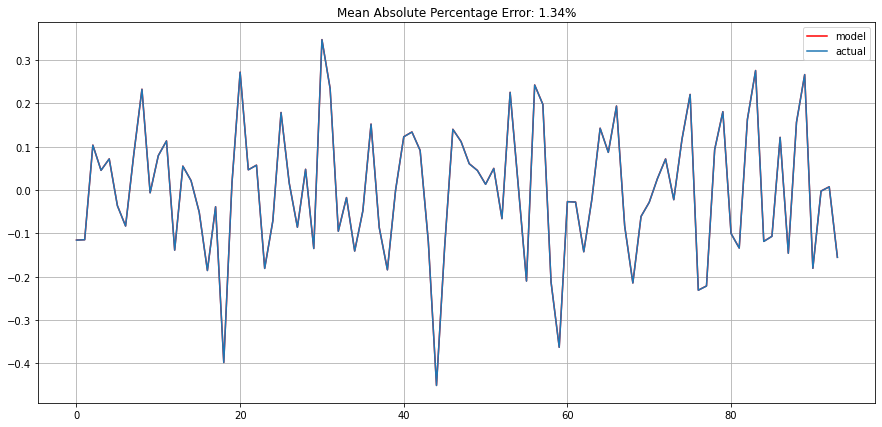

In [17]:
plotGARCH(series, am, 5)